### Import required libraries

In [1]:
import numpy as np
#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import numpy.linalg as la
import sys, os
import pickle
#import rbf as RBF
import warnings

import geopandas #for importing data from shapefiles/geodb

#import vista #for plotting


### Import submodules for FME

In [2]:
from FME.geological_points import IePoint, IPoint, GPoint, TPoint
from FME.geological_interpolator import GeologicalInterpolator
from FME.tet_mesh import TetMesh
from FME.dsi_interpolator import DSI
from FME.foldframe import FoldFrame
from FME.fold import FoldEvent, DSIFoldConstraint
#from FME.structural_frame import StructuralFrame
from FME.fault_segment import FaultSegment
from FME.region_manager import RegionManager
from FME.helper import *
from FME.svariogram import s_variogram#
#from FME import * #import all of the "public" functions from FME

### Define the model area and mesh using tetmesh

In [3]:
boundary_points = np.zeros((2,3))
boundary_points[0,0] = -20
boundary_points[0,1] = -20
boundary_points[0,2] = -20
boundary_points[1,0] = 20
boundary_points[1,1] = 20
boundary_points[1,2] = 20
mesh = TetMesh('Model','./')
mesh.setup_mesh(boundary_points,nstep=1,n_tetra=100000)

### Create a DSI interpolation object for stratigraphy
* DSI needs to be given a within the mesh - by default this is everywhere which is the whole mesh.
* It needs to know the shape of the interpolation matrix e.g. do you want to assemble the least squares constraints as a rectangular matrix and solve 
$Ax=b A^TAx=A^TB$ 
or do you want to assemble $A^TA$ directly?
For standard DSI where only observations and a regularisation term are used either are fine but where multiple mesh wide constraints are used it can be beneficial to use the square format.
* There are multiple options for solvers that are directly incorporated into FME - for example scipy lsmr, lsqr, SuiteSpare SPQR, SuiteSparse Cholmod, scipy LU. In general a direct solver e.g. cholmod is the fastest option, however for really large meshes or small computers an iterative solver would be better. 
* There are some numerical problems using cholmod that need to be further investigated
* The weighting of the regularisation term should be defined relative to the number of elements in the mesh to avoid scaling issues when changing the size of the mesh. 

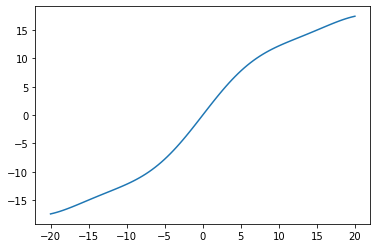

In [4]:
x = np.linspace(-20,20,100)
y = 0.4*x+np.sin(x/3)+np.sin(x/10)*10
plt.plot(x,y)

In [5]:
stratigraphy = DSI(mesh,region='everywhere',shape='square')
# for i in range(-15,15):
#     for j in range(-10,10):
#         stratigraphy.add_point([i,j,3*np.sin(j/5)],0.)
#         stratigraphy.add_point([i,j,3*np.sin(j/5)+1],1.)
# stratigraphy.add_strike_dip_and_value([2.1,0.1,1.1],190.,70.,0.)
for y in range(-18,18,1):
    stratigraphy.add_strike_dip_and_value([-10,y,-10],90.,0.,0.)
    stratigraphy.add_strike_dip_and_value([0,y,-6],90.,40.,0.)
    stratigraphy.add_strike_dip_and_value([5,y,7.1],90.,0.,0.)
#     stratigraphy.add_point([-10,y,-10],0.)
#     stratigraphy.add_point([0,y,-6],0.)
#     stratigraphy.add_point([5,y,7.1],0.)
stratigraphy.add_point([0.1,0,2.1],1.)
# stratigraphy.add_strike_and_dip([6.1,0.1,-15.1],90.,0.)
# stratigraphy.add_strike_and_dip([1.1,0.1,-15.1],90.,0.)
# stratigraphy.add_strike_and_dip([1.1,1.1,-15.1],90.,0.)
cgw = 100 / mesh.n_elements
stratigraphy.setup_interpolator(cgw=0.1)
# stratigraphy.calculate_constant_gradient_with_element_weighting(w)
stratigraphy.solve_system(solver='chol',clear=True)
mesh.update_property('strati',stratigraphy.c)
stratigraphy.export_data_to_vtk('stratig')

Setting up interpolator with 109 value control points 
        108 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.100000


### We can visualise isosurfaces of the interpolated scalar field using interactive lavavu
* lv_plot_isosurface takes a minimum of propertyname and isovalue. It will create a temporary lavavu viewer and plot a static image of the isosurface
* You can pass a lv object to the function using the argument lv and set draw to False and the surface will be added to the lavavu object. 
* The lavavu control panel can be used for interactively displaying object and an inline interactive viewer can be invoked by calling control.show()  


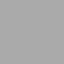

In [6]:
import lavavu
lv = lavavu.Viewer()
mesh.lv_plot_isosurface('strati',0,name='Strati0',interactive=False,lv=lv,draw=False)
mesh.lv_plot_isosurface('strati',1,name='Strati1',interactive=False,lv=lv,draw=False,colour='red')
# mesh.lv_plot_isosurface('strati',2,name='Strati2',interactive=False,lv=lv,draw=False)

cp_points = lv.points("points",pointsize=4,pointtype="sphere")
cp_points.vertices(stratigraphy.get_control_points()[:,:3])#mesh.nodes[mesh.elements[logic]])
cp_points.values(stratigraphy.get_control_points()[:,3:])#mesh.nodes[mesh.elements[logic]])

gcp_points= lv.vectors("points2",pointsize=4,pointtype="sphere",colour='red')
gcp_points.vertices(stratigraphy.get_gradient_control()[:,:3])
gcp_points.vectors(stratigraphy.get_gradient_control()[:,3:])
lv.control.Panel()
lv.control.ObjectList()
    # lv.reload()
lv.control.show()#nterac
#lv.interactive()

### Static visualisation
* We can use the previous lavavu viewer to define a viewing angle and then display a static image for export


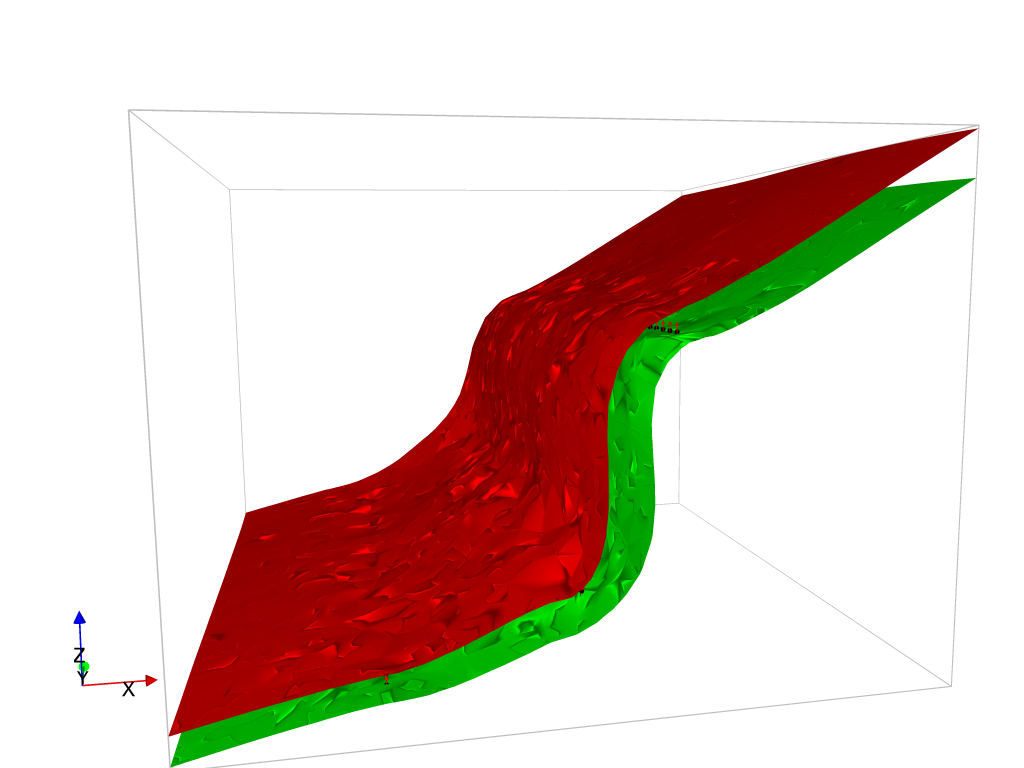

''

In [7]:
#static display
lv.display()

lv.image('./data/interpolate_example.jpg')

In [9]:
lv.interactive()